# Analysis of experiment 1

So our goal in Experiment 1 is to assign metadata to each clone with the following information:

1.  Clone Size (number of cells)
2.  Clone Cell type (CD4 or CD8)
3.  Clone Gene expression (Genes that identify this clone well – clonal gene signature)
4.  IL2RA expression level
5.  IL7R expression level

Some of this has already been done during preprocessing.


# Loading packages

In [1]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
import anndata
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

/opt/miniconda3/envs/clonalomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Loading data

In [3]:
ad = {}
samples = ['Sample{}'.format(j) for j in [1,2,3,4,5,6]]
cd_types = ['CD4','CD8']
datasets = [(sample, cd_type) for sample in samples for cd_type in cd_types]
for sample in samples:
    for cd_type in cd_types:
        filename = 'Processed/JM_10X_exp1_'+sample+'_'+cd_type+'.loom'
        ad[(sample,cd_type)] = sc.read_loom(filename) 

In [4]:
ad[('Sample1','CD4')]

AnnData object with n_obs × n_vars = 840 × 16012
    obs: 'CD_type', 'clone', 'clone_ID', 'experiment', 'hash_ID', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'nCount_CH', 'nCount_RNA', 'nFeature_CH', 'nFeature_RNA', 'n_genes_by_counts', 'orig_ident', 'pct_counts_mt', 'percent_mt', 'total_counts', 'total_counts_mt', 'well'
    var: 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'variances', 'variances_norm'

# Clone populations

In [5]:
ds = datasets[0]
ds

('Sample1', 'CD4')

In [6]:
ad[ds].obs.clone.value_counts()

1     477
15    222
18     82
13     57
46      2
Name: clone, dtype: int64

In [7]:
clonepops = pd.DataFrame(index = ['Clone_{}'.format(j) for j in range(1,10)], 
                        columns=[ds[0]+'_'+ds[1] for ds in datasets])
for ds in datasets:
    col = ds[0]+'_'+ds[1]
    vc = ad[ds].obs.clone.value_counts()
    for j in range(len(vc)):
        clonepops.loc['Clone_{}'.format(j+1), col] = vc.iloc[j]

clonepops

,Sample1_CD4,Sample1_CD8,Sample2_CD4,Sample2_CD8,Sample3_CD4,Sample3_CD8,Sample4_CD4,Sample4_CD8,Sample5_CD4,Sample5_CD8,Sample6_CD4,Sample6_CD8
Clone_1,477,269,1180,263,988,145,542,536,1527,269,908,220
Clone_2,222,NaN,309,NaN,357,36,482,NaN,11,55,520,74
Clone_3,82,NaN,100,NaN,174,10,241,NaN,NaN,5,39,NaN
Clone_4,57,NaN,7,NaN,NaN,NaN,127,NaN,NaN,NaN,NaN,NaN
Clone_5,2,NaN,1,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN
Clone_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Clone_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Clone_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Clone_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
clonepops.to_csv('exp1_clonepops.csv')

# Clonal gene analysis

## Filtering data

Here we filter our datasets to keep only clones with at least 10 cells, and keeping only genes which are expressed by at least 5% of (remaining) cells.  

In [9]:
ad[ds].obs_names

Index(['exp1_AAACCTGGTCTCAACA-1', 'exp1_AAACGGGCATTCACTT-1',
       'exp1_AAAGCAACATCCCACT-1', 'exp1_AAAGCAATCAATCTCT-1',
       'exp1_AACACGTGTAAACACA-1', 'exp1_AACGTTGCAATCCAAC-1',
       'exp1_AACTCTTGTACCGTAT-1', 'exp1_AACTGGTCAGTGACAG-1',
       'exp1_AACTTTCGTCGAACAG-1', 'exp1_AAGACCTAGTTGTCGT-1',
       ...
       'exp1_TTGCGTCTCTCTGAGA-1', 'exp1_TTGGAACCAAGTACCT-1',
       'exp1_TTGGCAAGTCACCCAG-1', 'exp1_TTGTAGGCAGACGCCT-1',
       'exp1_TTTACTGGTTCAGACT-1', 'exp1_TTTATGCTCCCTTGCA-1',
       'exp1_TTTATGCTCTGGCGTG-1', 'exp1_TTTCCTCGTACCTACA-1',
       'exp1_TTTGGTTGTCCAGTTA-1', 'exp1_TTTGGTTGTGTGCCTG-1'],
      dtype='object', name='CellID', length=294)

In [10]:
for ds in datasets:
    vc = ad[ds].obs.clone.value_counts()
    bigclones = vc[vc >= 10].index
    goodcells = ad[ds].obs[ad[ds].obs.clone.isin(bigclones)].index
    print('Filtering {} cells down to {} cells'.format(len(ad[ds].obs), len(goodcells)))
    ad[ds] = ad[ds][goodcells]

Filtering 840 cells down to 838 cells
Filtering 269 cells down to 269 cells
Filtering 1597 cells down to 1589 cells
Filtering 263 cells down to 263 cells
Filtering 1519 cells down to 1519 cells
Filtering 191 cells down to 191 cells
Filtering 1467 cells down to 1467 cells
Filtering 536 cells down to 536 cells
Filtering 1538 cells down to 1538 cells
Filtering 329 cells down to 324 cells
Filtering 1467 cells down to 1467 cells
Filtering 294 cells down to 294 cells


In [11]:
for ds in datasets:
    X = ad[ds].to_df()
    dropout = ((X == 0.0).sum() / len(X))
    goodgenes = dropout[dropout <= 0.95].index
    print('Filtering {} genes down to {} genes'.format(len(ad[ds].var), len(goodgenes)))
    ad[ds].var['dropout'] = dropout
    ad[ds] = ad[ds][:,goodgenes]

Filtering 16012 genes down to 8508 genes
Filtering 13971 genes down to 7951 genes
Filtering 17380 genes down to 8865 genes
Filtering 13733 genes down to 8565 genes
Filtering 16945 genes down to 7800 genes
Filtering 13019 genes down to 8274 genes


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.va

Filtering 17237 genes down to 8201 genes
Filtering 14825 genes down to 8233 genes
Filtering 16999 genes down to 9197 genes
Filtering 13899 genes down to 8783 genes
Filtering 17865 genes down to 8330 genes
Filtering 13788 genes down to 8248 genes


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.va

## Clonal gene analysis

We find clonal genes, adjusting p-values by Bonferroni as well as a custom dropout-based multiplier.  (p-value gets adjusted by multiplying by 1/(1-dropout), so a gene with 95% dropout gets p-value multiplied by 1/0.05 = 20.)  This works well enough, empirically, to adjust for the fact that dropout increases frequency of low p-values by chance alone.  We perform a permutation test to estimate false discoveries in the end.

In [12]:
nperm = 100

for ds in datasets:
    X = ad[ds].to_df()
    y = ad[ds].obs.clone
    # Make a dataframe of shuffled clone labels.
    yshuff_df = pd.DataFrame(index = y.index, columns=range(nperm))
    yshuff_df = pd.concat([y.astype(str) for j in range(nperm)], axis=1) # Concat nperm copies of y.
    ys_vals = yshuff_df.values
    [np.random.shuffle(x) for x in ys_vals.T]
    yshuff_df.columns = ['Shuffle_{}'.format(j) for j in range(nperm)]
    for col in yshuff_df.columns:
        ad[ds].obs[col] = yshuff_df[col]
    print('Created {} permuted clone labels for dataset {}'.format(nperm, ds))

Created 100 permuted clone labels for dataset ('Sample1', 'CD4')
Created 100 permuted clone labels for dataset ('Sample1', 'CD8')
Created 100 permuted clone labels for dataset ('Sample2', 'CD4')
Created 100 permuted clone labels for dataset ('Sample2', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/1406422706.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad[ds].obs[col] = yshuff_df[col]
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].obs[col] = yshuff_df[col]
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].obs[col] = yshuff

Created 100 permuted clone labels for dataset ('Sample3', 'CD4')
Created 100 permuted clone labels for dataset ('Sample3', 'CD8')
Created 100 permuted clone labels for dataset ('Sample4', 'CD4')
Created 100 permuted clone labels for dataset ('Sample4', 'CD8')
Created 100 permuted clone labels for dataset ('Sample5', 'CD4')
Created 100 permuted clone labels for dataset ('Sample5', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/1406422706.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad[ds].obs[col] = yshuff_df[col]
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].obs[col] = yshuff_df[col]
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].obs[col] = yshuff

Created 100 permuted clone labels for dataset ('Sample6', 'CD4')
Created 100 permuted clone labels for dataset ('Sample6', 'CD8')


In [13]:
datasets_cl = []
for ds in datasets:
    X = ad[ds].to_df()
    y = ad[ds].obs.clone
    if len(np.unique(y)) > 1:
        F_pvals = ss.f_oneway(*[X[y == k] for k in np.unique(y)])[1]
        ad[ds].var['F_pval'] = F_pvals
        for j in range(nperm):
            ys = ad[ds].obs['Shuffle_{}'.format(j)]
            F_pvals = ss.f_oneway(*[X[ys == k] for k in np.unique(ys)])[1]
            ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
        print('Computed p-values for {} permuted clone labels for dataset {}'.format(nperm, ds))
        datasets_cl.append(ds)
    else:
        print('{} has only one clone'.format(ds))
    

/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample1', 'CD4')
('Sample1', 'CD8') has only one clone


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample2', 'CD4')
('Sample2', 'CD8') has only one clone


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample3', 'CD4')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample3', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample4', 'CD4')
('Sample4', 'CD8') has only one clone


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample5', 'CD4')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample5', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample6', 'CD4')
Computed p-values for 100 permuted clone labels for dataset ('Sample6', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [14]:
for ds in datasets_cl:
    for col in ['F_pval'] + ['F_pval_Shuffle_{}'.format(j) for j in range(nperm)]:
        Fp = ad[ds].var[col]
        Ap = Fp / (1 - ad[ds].var['dropout']) # Custom dropout-based adjustment
        Ap = Ap * len(Ap) # Bonferonni adjustment
        Ap = np.minimum(Ap,1.0)
        ad[ds].var['Adj_'+col] = Ap
    print('Adjusted p-values for {}'.format(ds))

/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['Adj_'+col] = Ap
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['Adj_'+col] = Ap
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

Adjusted p-values for ('Sample1', 'CD4')
Adjusted p-values for ('Sample2', 'CD4')
Adjusted p-values for ('Sample3', 'CD4')
Adjusted p-values for ('Sample3', 'CD8')
Adjusted p-values for ('Sample4', 'CD4')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['Adj_'+col] = Ap
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['Adj_'+col] = Ap
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

Adjusted p-values for ('Sample5', 'CD4')
Adjusted p-values for ('Sample5', 'CD8')
Adjusted p-values for ('Sample6', 'CD4')
Adjusted p-values for ('Sample6', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['Adj_'+col] = Ap
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['Adj_'+col] = Ap
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_50451/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

In [15]:
sig_genes = {}
for i,ds in enumerate(datasets_cl):
    sg = (ad[ds].var['Adj_F_pval'].sort_values() < 0.05)
    sig_genes[ds] = sg[sg].index
    sh_cols = ['Adj_F_pval_Shuffle_{}'.format(j) for j in range(nperm)]
    sg_df = (ad[ds].var[sh_cols] < 0.05)
    FDs = sg_df.sum().mean()
    print('{} clonal genes found in {}, with {} expected by chance.'.format(len(sig_genes[ds]), ds, FDs))

323 clonal genes found in ('Sample1', 'CD4'), with 0.01 expected by chance.
285 clonal genes found in ('Sample2', 'CD4'), with 0.05 expected by chance.
386 clonal genes found in ('Sample3', 'CD4'), with 0.01 expected by chance.
45 clonal genes found in ('Sample3', 'CD8'), with 0.57 expected by chance.
517 clonal genes found in ('Sample4', 'CD4'), with 0.04 expected by chance.
21 clonal genes found in ('Sample5', 'CD4'), with 0.98 expected by chance.
33 clonal genes found in ('Sample5', 'CD8'), with 0.05 expected by chance.
475 clonal genes found in ('Sample6', 'CD4'), with 0.1 expected by chance.
49 clonal genes found in ('Sample6', 'CD8'), with 0.02 expected by chance.


In [16]:
sig_gene_df = pd.DataFrame(columns = datasets_cl, index=['Gene_{}'.format(j) for j in range(1,600)])
for ds in datasets_cl:
    for j,gene in enumerate(sig_genes[ds]):
        sig_gene_df[ds].loc['Gene_{}'.format(j+1)] = gene
display(sig_gene_df)

,"(Sample1, CD4)","(Sample2, CD4)","(Sample3, CD4)","(Sample3, CD8)","(Sample4, CD4)","(Sample5, CD4)","(Sample5, CD8)","(Sample6, CD4)","(Sample6, CD8)"
Gene_1,ARMH1,CCL5,NOSIP,NKG7,TCF7,ANXA3,MAL,GSTM2,KLRC1
Gene_2,CCR7,NKG7,IL7R,HOPX,PLAC8,IL4I1,TRG-AS1,CD7,XCL1
Gene_3,MT-CO3,PECAM1,SP140,AOAH,SPINT2,NETO2,CD44,CCL5,AHNAK
Gene_4,NCF4,BEX3,LEF1,PASK,CD7,CCR7,LAG3,IFITM2,RAMP1
Gene_5,IFITM2,ENPP3,CXCR6,CTSW,LEF1,AZIN1-AS1,LITAF,PLAAT3,CD8B
...,...,...,...,...,...,...,...,...,...
Gene_595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gene_598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
sig_gene_df.to_csv('exp1_clonalgenes.csv')

In [18]:
ad[ds].var

,highly_variable,highly_variable_rank,log1p_mean_counts,log1p_total_counts,mean_counts,means,mt,n_cells_by_counts,n_counts,pct_dropout_by_counts,...,Adj_F_pval_Shuffle_90,Adj_F_pval_Shuffle_91,Adj_F_pval_Shuffle_92,Adj_F_pval_Shuffle_93,Adj_F_pval_Shuffle_94,Adj_F_pval_Shuffle_95,Adj_F_pval_Shuffle_96,Adj_F_pval_Shuffle_97,Adj_F_pval_Shuffle_98,Adj_F_pval_Shuffle_99
Gene,,,,,,,,,,,,,,,,,,,,,
NOC2L,0,NaN,0.149102,5.926926,0.160791,0.160791,0,350,47.676212,84.952709,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ISG15,0,NaN,0.237994,6.439351,0.268702,0.268702,0,527,90.869904,77.343078,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
C1orf159,0,NaN,0.031319,4.317488,0.031814,0.031814,0,74,22.857210,96.818573,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
TNFRSF18,1,191.0,0.248779,6.489205,0.282459,0.282459,0,461,68.260010,80.180567,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
TNFRSF4,1,110.0,0.469574,7.240650,0.599312,0.599312,0,830,47.539009,64.316423,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4,0,NaN,1.633480,9.168267,4.121668,4.121668,1,2212,576.556946,4.901118,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MT-ND5,0,NaN,1.782690,9.350537,4.945830,4.945830,1,2217,585.819763,4.686156,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MT-ND6,1,962.0,0.748955,7.860956,1.114789,1.114789,1,1360,205.390244,41.530525,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
for ds in datasets_cl:
    gene_df = ad[ds].var[['dropout','highly_variable','F_pval','Adj_F_pval']].sort_values(by='Adj_F_pval')
    gene_df.to_csv('exp1_'+ds[0]+'_'+ds[1]+'_genelist.csv')

# Well differences.

Now that we've found clone-specific genes within each well (sample), we look for well-specific differences.

In [20]:
datasets

[('Sample1', 'CD4'),
 ('Sample1', 'CD8'),
 ('Sample2', 'CD4'),
 ('Sample2', 'CD8'),
 ('Sample3', 'CD4'),
 ('Sample3', 'CD8'),
 ('Sample4', 'CD4'),
 ('Sample4', 'CD8'),
 ('Sample5', 'CD4'),
 ('Sample5', 'CD8'),
 ('Sample6', 'CD4'),
 ('Sample6', 'CD8')]

In [21]:
ad_all = {}
for cd in cd_types:
    dss = [ds for ds in datasets if ds[1] == cd]
    ad_all[cd] = anndata.concat([ad[ds] for ds in dss]).copy()

In [22]:
ad_all['CD4'].obs['well']

CellID
exp1_AAACCTGTCCGCATAA-1    Sample1
exp1_AAAGTAGCAGCTATTG-1    Sample1
exp1_AAAGTAGCATGCAACT-1    Sample1
exp1_AAAGTAGTCGGGAGTA-1    Sample1
exp1_AAATGCCCATCCAACA-1    Sample1
                            ...   
exp1_TTTGGTTAGGAGTCTG-1    Sample6
exp1_TTTGGTTTCCGCAGTG-1    Sample6
exp1_TTTGGTTTCCTTGCCA-1    Sample6
exp1_TTTGTCACACTTCGAA-1    Sample6
exp1_TTTGTCATCAAGGTAA-1    Sample6
Name: well, Length: 8418, dtype: object

Here we compute dropout rates for each gene (all samples together), and run analysis of well-to-well variance.

In [27]:
for cd in cd_types:
    X = ad_all[cd].to_df()
    dropout = ((X == 0.0).sum() / len(X))
    ad_all[cd].var['dropout'] = dropout
    y = ad_all[cd].obs.well
    if len(np.unique(y)) > 1:
        Fp = ss.f_oneway(*[X[y == k] for k in np.unique(y)])[1]
        ad_all[cd].var['F_pval_well'] = Fp
        Ap = Fp / (1 - ad_all[cd].var['dropout']) # Custom dropout-based adjustment
        Ap = Ap * len(Ap) # Bonferonni adjustment
        Ap = np.minimum(Ap,1.0)
        display(Ap)
        ad_all[cd].var['adj_F_pval_well'] = Ap

Gene
NOC2L          1.000000e+00
ISG15         1.652224e-313
TNFRSF18      1.180551e-138
TNFRSF4       4.630478e-160
SDF4           8.788430e-23
                  ...      
MT-ND4        2.141213e-219
MT-ND5         8.722492e-84
MT-ND6         3.231783e-12
MT-CYB        6.730029e-241
AL592183.1     1.000000e+00
Name: dropout, Length: 7345, dtype: float64

Gene
NOC2L         1.000000e+00
ISG15         1.392729e-09
SDF4          1.000000e+00
UBE2J2        1.000000e+00
PUSL1         1.000000e+00
                  ...     
MT-ND4        1.000000e+00
MT-ND5        1.000000e+00
MT-ND6        1.000000e+00
MT-CYB        9.284192e-05
AL592183.1    1.000000e+00
Name: dropout, Length: 7084, dtype: float64

In [28]:
ad_all[cd].var

,dropout,F_pval_well,adj_F_pval_well
Gene,,,
NOC2L,0.854022,1.065945e-01,1.000000e+00
ISG15,0.669686,6.494046e-14,1.392729e-09
SDF4,0.574853,9.492335e-04,1.000000e+00
UBE2J2,0.742674,4.778186e-02,1.000000e+00
PUSL1,0.913692,5.557200e-01,1.000000e+00
...,...,...,...
MT-ND4,0.062334,6.049540e-03,1.000000e+00
MT-ND5,0.054342,8.373753e-04,1.000000e+00
MT-ND6,0.455514,4.458122e-01,1.000000e+00


In [29]:
ad_all[cd].var.sort_values(by='F_pval_well')

,dropout,F_pval_well,adj_F_pval_well
Gene,,,
ITM2A,0.447523,1.939727e-120,2.487165e-116
AOAH,0.315397,1.149130e-113,1.189074e-109
IL4R,0.485882,2.960838e-91,4.079719e-87
IL7R,0.689931,1.771320e-90,4.046849e-86
CCL5,0.013852,1.476293e-79,1.060496e-75
...,...,...,...
LMTK2,0.906233,9.980606e-01,1.000000e+00
SUCO,0.777304,9.981195e-01,1.000000e+00
RCN1,0.924880,9.988395e-01,1.000000e+00


In [76]:
well_genes = {}
for cd in cd_types:
    Ap = ad_all[cd].var['adj_F_pval_well']
    well_genes[cd] = Ap[Ap < 1e-2].sort_values().index
    print('{} well genes found in {}'.format(len(well_genes[cd]), cd))

4425 well genes found in CD4
611 well genes found in CD8


In [43]:
ad_all[cd].obs.clone.unique()

array(['17', '23', '36', '29', '45', '14', '31', '16', '26', '41'],
      dtype=object)

In [41]:
ad_all[cd].obs['well']

CellID
exp1_AAACGGGTCGAATCCA-1    Sample1
exp1_AACCATGTCACTTCAT-1    Sample1
exp1_AACCATGTCCCTAACC-1    Sample1
exp1_AACTCCCCAAAGGTGC-1    Sample1
exp1_AAGACCTCAACTTGAC-1    Sample1
                            ...   
exp1_TTTATGCTCCCTTGCA-1    Sample6
exp1_TTTATGCTCTGGCGTG-1    Sample6
exp1_TTTCCTCGTACCTACA-1    Sample6
exp1_TTTGGTTGTCCAGTTA-1    Sample6
exp1_TTTGGTTGTGTGCCTG-1    Sample6
Name: well, Length: 1877, dtype: object

In [70]:
wc = {}
clones = {}
ccuts = {}
for cd in cd_types:
    wc[cd] = ad_all[cd].obs[['well','clone']].value_counts().sort_index().index
    clones[cd] = [mi[1] for mi in wc[cd]]
    ccuts[cd] = pd.Series([mi[0] for mi in wc[cd]]).value_counts().sort_index().cumsum()
    
    

In [71]:
pd.Series([mi[0] for mi in wc[cd]]).value_counts().sort_index()

Sample1    1
Sample2    1
Sample3    3
Sample4    1
Sample5    2
Sample6    2
dtype: int64

In [154]:
samples

['Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5', 'Sample6']

In [155]:
datasets

[('Sample1', 'CD4'),
 ('Sample1', 'CD8'),
 ('Sample2', 'CD4'),
 ('Sample2', 'CD8'),
 ('Sample3', 'CD4'),
 ('Sample3', 'CD8'),
 ('Sample4', 'CD4'),
 ('Sample4', 'CD8'),
 ('Sample5', 'CD4'),
 ('Sample5', 'CD8'),
 ('Sample6', 'CD4'),
 ('Sample6', 'CD8')]

In [158]:
L = [1,2,3]
L = L + [4,5,6]
L

[1, 2, 3, 4, 5, 6]

In [170]:
list(well_genes[cd][:5])

['ITM2A', 'AOAH', 'IL4R', 'IL7R', 'CCL5']

In [168]:
list(sig_genes[ds][:5])

['KLRC1', 'XCL1', 'AHNAK', 'RAMP1', 'CD8B']

In [190]:
def mydot(cd):
    X = ad_all[cd].to_df()
    y = ad_all[cd].obs['clone']
    X_z = (X - X.mean()) / X.std()
    gmeans = X_z.groupby(y).mean()
    genelist = list(well_genes[cd][:30])
    for sample in samples:
        ds = (sample, cd)
        genelist = genelist + list(sig_genes[ds][:10])
    genelist = [gene for gene in genelist if gene in X.columns]
    on_ratios = (X[genelist].groupby(y).apply(lambda col : (col>0).sum() / len(col))).melt(ignore_index=False)
    plot_data = gmeans[genelist].melt(ignore_index=False)
    plot_data['clone'] = plot_data.index
    plot_data['clone'] = pd.Categorical(plot_data['clone'],
                                       categories=clones[cd],
                                       ordered=True)
    plot_data['zscore'] = plot_data['value']
    plot_data['on_ratio'] = on_ratios['value']
    
    width=len(clones[cd]) / 2
    height = len(genelist) / 2.5
    fig,ax = plt.subplots(1,1,figsize=(width, height))
    sns.set_style('white')
    sns.scatterplot(x='clone', y='Gene', hue='zscore', size='on_ratio', sizes=(20,200), data=plot_data, ax=ax,
                   palette='inferno', vmin=-2, vmax=2)

    sns.move_legend(ax, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    ax.set_xticks(clones[cd])
    for c in ccuts[cd][:-1]:
        ax.axvline(c - 0.5)
    ax.axhline(29.5)

    plt.suptitle('Gene expression among clones and wells:  {} {} cells'.format(len(X), cd))
    plt.show()

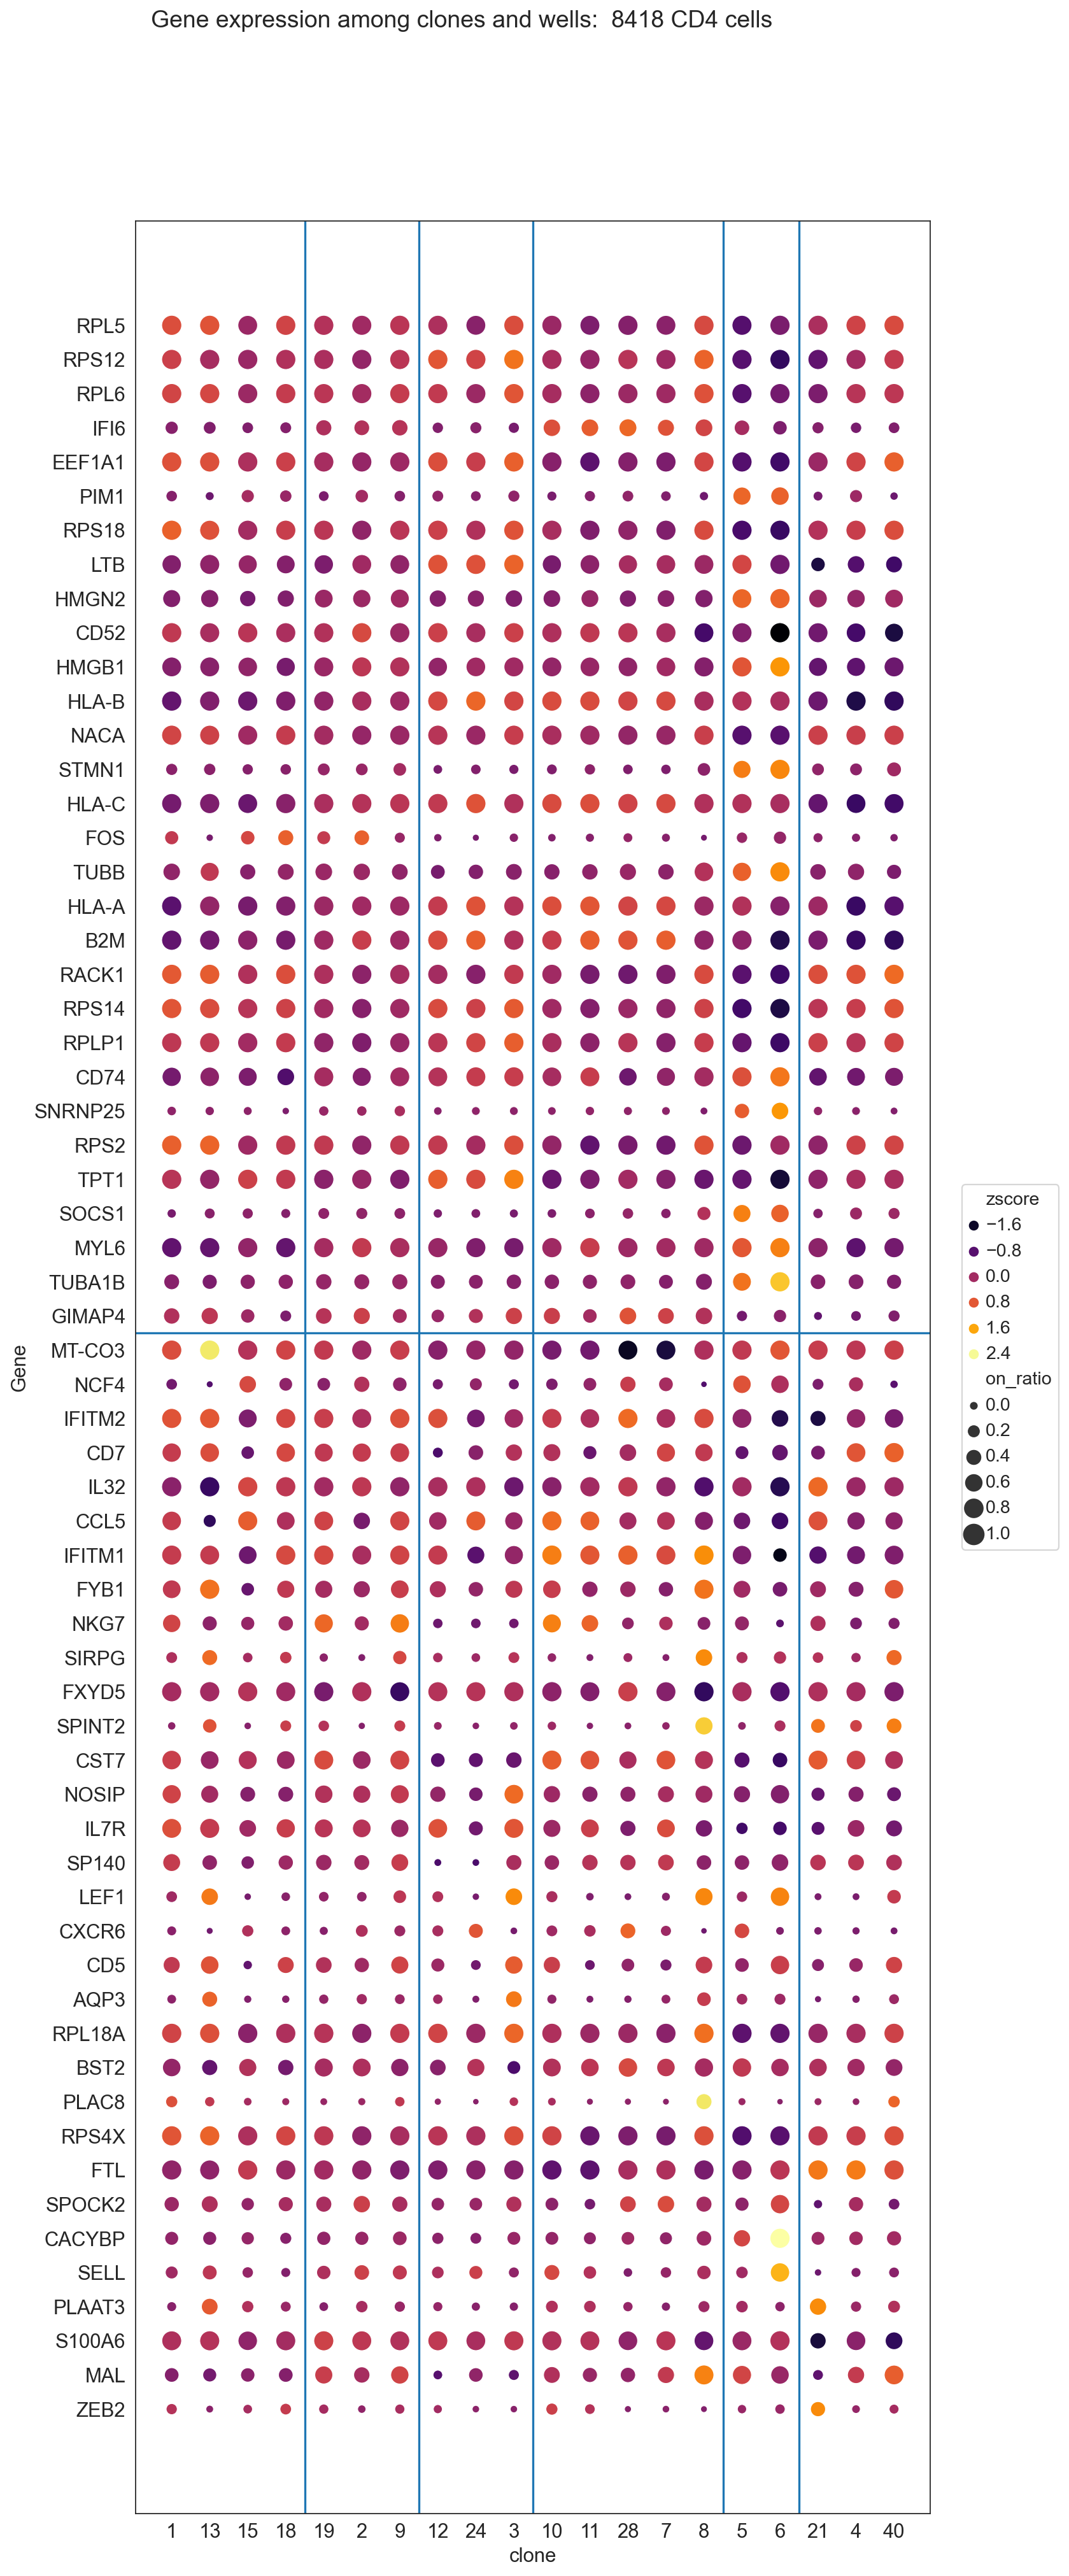

In [191]:
mydot('CD4')

In [92]:
wc[cd]

MultiIndex([('Sample1', '17'),
            ('Sample2', '23'),
            ('Sample3', '29'),
            ('Sample3', '36'),
            ('Sample3', '45'),
            ('Sample4', '14'),
            ('Sample5', '16'),
            ('Sample5', '31'),
            ('Sample6', '26'),
            ('Sample6', '41')],
           names=['well', 'clone'])

# IL2RA and IL7R expression

In [ ]:
fig,ax = plt.subplots(2,6,figsize=(18,7), sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

for i,cd_type in enumerate(cd_types):
    for j,sample in enumerate(samples):
        ax_now = ax[i,j]
        ds = (sample, cd_type)
        sc.pl.violin(ad[ds], 'IL2RA', groupby='clone', ax=ax_now, show=False)
        ax_now.set_title('{}, {}'.format(sample,cd_type))
        ax_now.set_xlabel('')
        ax_now.set_ylabel('')
        
plt.suptitle('Expression of IL2RA across clones', y=1.05)
plt.show()
    

In [ ]:
fig,ax = plt.subplots(2,6,figsize=(18,7), sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

for i,cd_type in enumerate(cd_types):
    for j,sample in enumerate(samples):
        ax_now = ax[i,j]
        ds = (sample, cd_type)
        sc.pl.violin(ad[ds], 'IL7R', groupby='clone', ax=ax_now, show=False)
        ax_now.set_title('{}, {}'.format(sample,cd_type))
        ax_now.set_xlabel('')
        ax_now.set_ylabel('')
        
plt.suptitle('Expression of IL7R across clones', y=1.05)
plt.show()

# Pooling CD4 and CD8s from all samples

In [ ]:
for cd_type in cd_types:
    key_list = [key for key in ad.keys() if key[1] == cd_type]
    if key_list:
        print(key_list)
        ad[(cd_type,'all')] = sc.concat([ad[key] for key in key_list], join="outer", index_unique=None)

In [ ]:
datasets_cl

In [ ]:
for cd_type in cd_types:
    gene_df = pd.DataFrame(columns=samples, index=ad[(cd_type,'all')].var.index)
    for sample in samples:
        if (sample, cd_type) in datasets_cl:
            gene_df[sample] = ad[(sample,cd_type)].var.Adj_F_pval
    p_mins = gene_df.min(axis=1)
    ad[(cd_type, 'all')].var['Adj_F_pval'] = p_mins

In [ ]:
ad[('CD8','all')].var['Adj_F_pval'].sort_values()

In [ ]:
ad[('CD4','all')].var['Adj_F_pval'].sort_values()[:100]

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
sc.pl.violin(ad[('CD4','all')], 'PDE4D', groupby='clone', ax=ax, show=False)
plt.show()

In [ ]:
ad[('CD4','all')].var['Adj_F_pval'].sort_values()[:500]